<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Изучение-исходной-информации" data-toc-modified-id="Изучение-исходной-информации-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Изучение исходной информации</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Изучение исходной информации

In [1]:
#подключим необходимые для работы библиотеки

import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
pd.options.display.float_format = '{:,.3f}'.format

import matplotlib.pyplot as plt
from scipy import stats as st
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error

In [2]:
#прочитаем исходный датафрейм

try:
    data = pd.read_csv('C:/Users/IshkulovIM/pythonworks/yandex_practikum/taxi.csv', sep=',', parse_dates=[0], index_col='datetime') 
    
except:
    data = pd.read_csv('/datasets/taxi.csv', sep=',',  parse_dates=[0], index_col='datetime')

In [3]:
# изучим основную информацию о датафрейме

print('Первые 10 строк датафрейма:')
display(data.head(10))
print('Основная информация о датафрейме:')
display(data.info())
display(data.describe())
print('Размер датасета:')
display(data.shape)
print('Доля пропущенных данных в датафрейме:')
display(data.isna().mean())
print('Количество дубликатов: ')
display(data.duplicated().sum())

Первые 10 строк датафрейма:


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Основная информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,"26,496.000"
mean,14.070
std,9.211
min,0.000
25%,8.000
50%,13.000
75%,19.000
max,119.000


Размер датасета:


(26496, 1)

Доля пропущенных данных в датафрейме:


num_orders   0.000
dtype: float64

Количество дубликатов: 


26415

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
В исходном датафрейме нам дан только столбец с количеством заказов и временной ряд, который мы использовали как индекс. Тип  данных обозначен корректно, пропусков в данных нет.
</div>

## Анализ

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Проверим в хронологическом ли порядке расположены даты и время.
</div>

In [4]:
data = data.sort_index()
print(data.index.is_monotonic)

True


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Даты и время в нашем датафрейме действительно расположены в хронологическом порядке. 
</div>

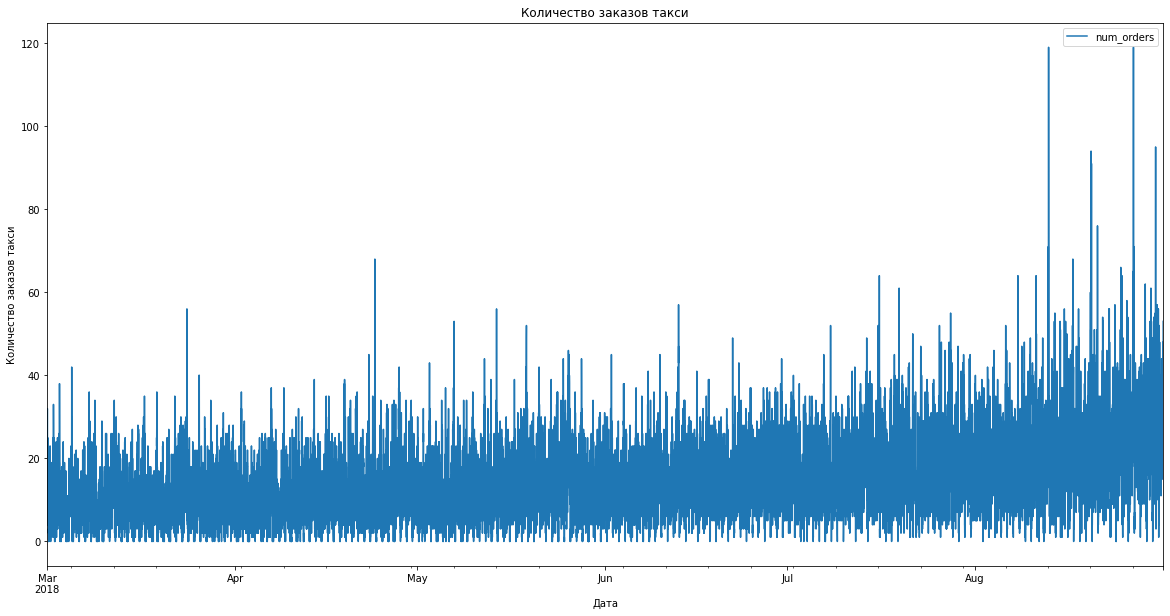

In [5]:
#далее построим график временного ряда

data.plot(figsize=(20,10))

plt.title('Количество заказов такси')
plt.xlabel('Дата')
plt.ylabel('Количество заказов такси')
plt.show()

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Далее провередем ресемплирование временного ряда по одному часу. Посмотрим какое количество заказов было в час на каждый временной шаг.
</div>

In [6]:
data = data.resample('1H').sum()

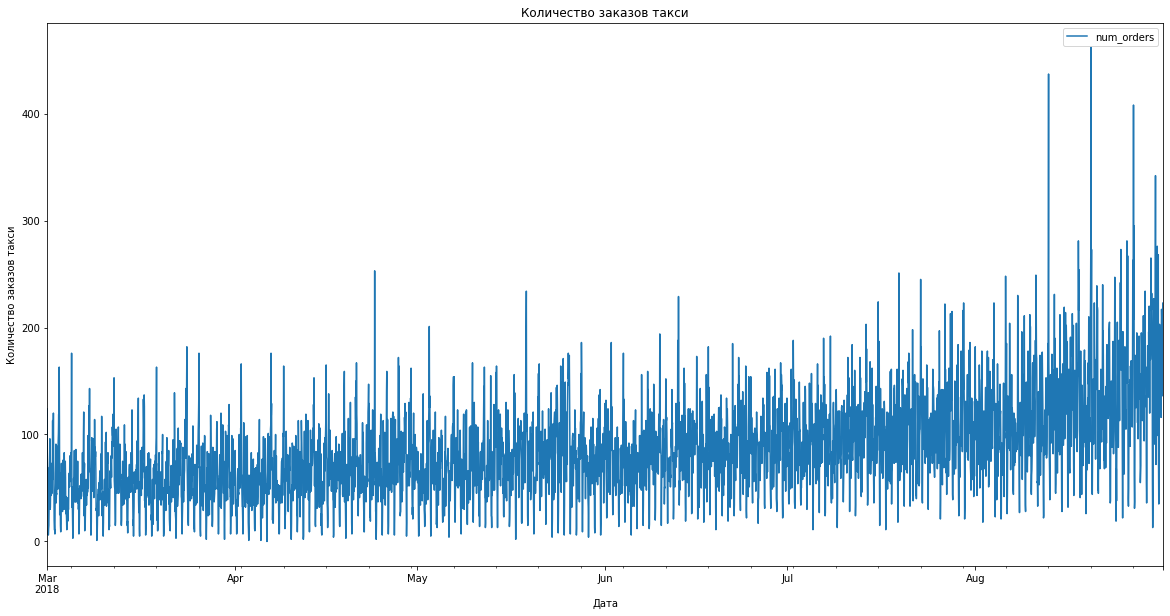

In [7]:
#далее построим график временного ряда

data.plot(figsize=(20,10))

plt.title('Количество заказов такси')
plt.xlabel('Дата')
plt.ylabel('Количество заказов такси')
plt.show()

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Стало заметно, что после ресемплирования график стал менее шумным. Разложим наш временной ряд на тренд и сезонную составляющую.
</div>

In [8]:
decomposed = seasonal_decompose(data) 

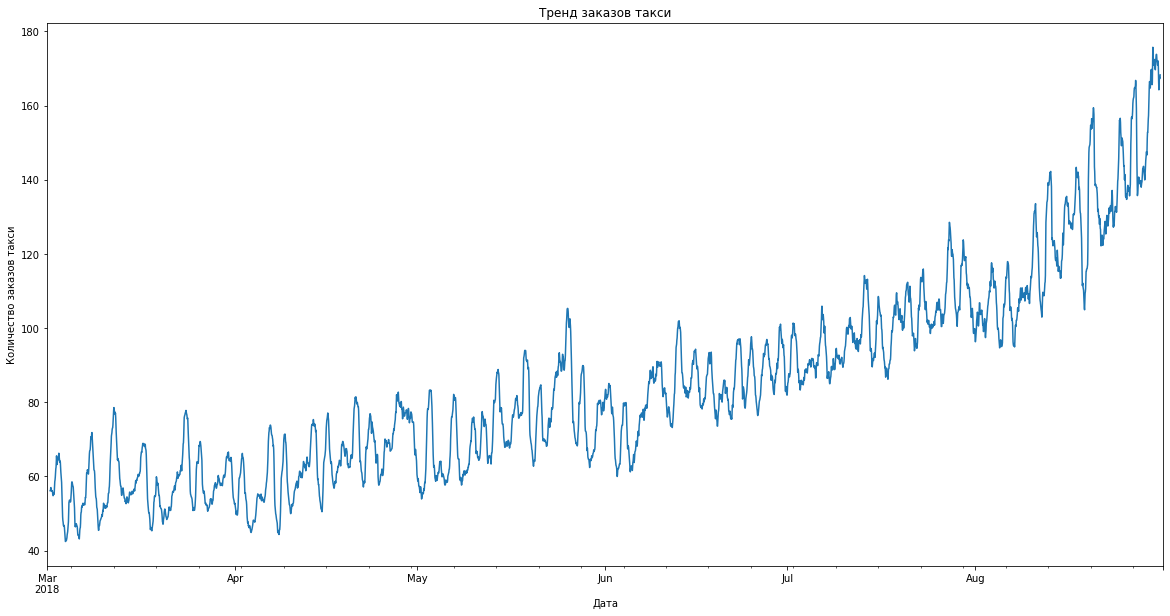

In [9]:
#посмотрим на график тренда 

decomposed.trend.plot(figsize=(20,10))

plt.title('Тренд заказов такси')
plt.xlabel('Дата')
plt.ylabel('Количество заказов такси')
plt.show()

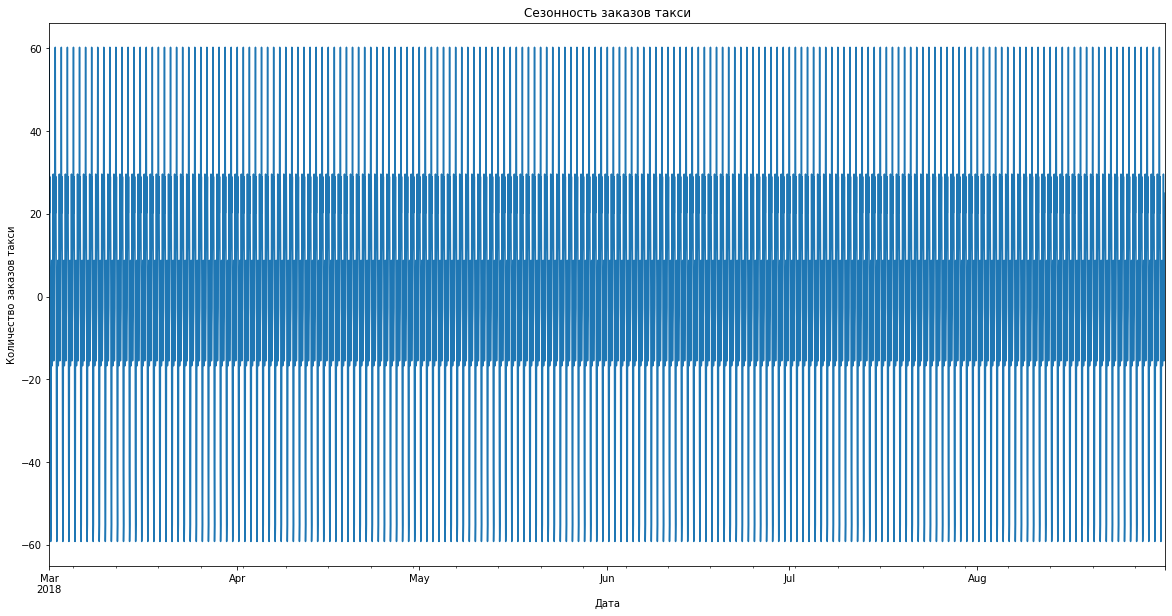

In [10]:
#посмотрим на график сезонности

decomposed.seasonal.plot(figsize=(20,10))

plt.title('Сезонность заказов такси')
plt.xlabel('Дата')
plt.ylabel('Количество заказов такси')
plt.show()

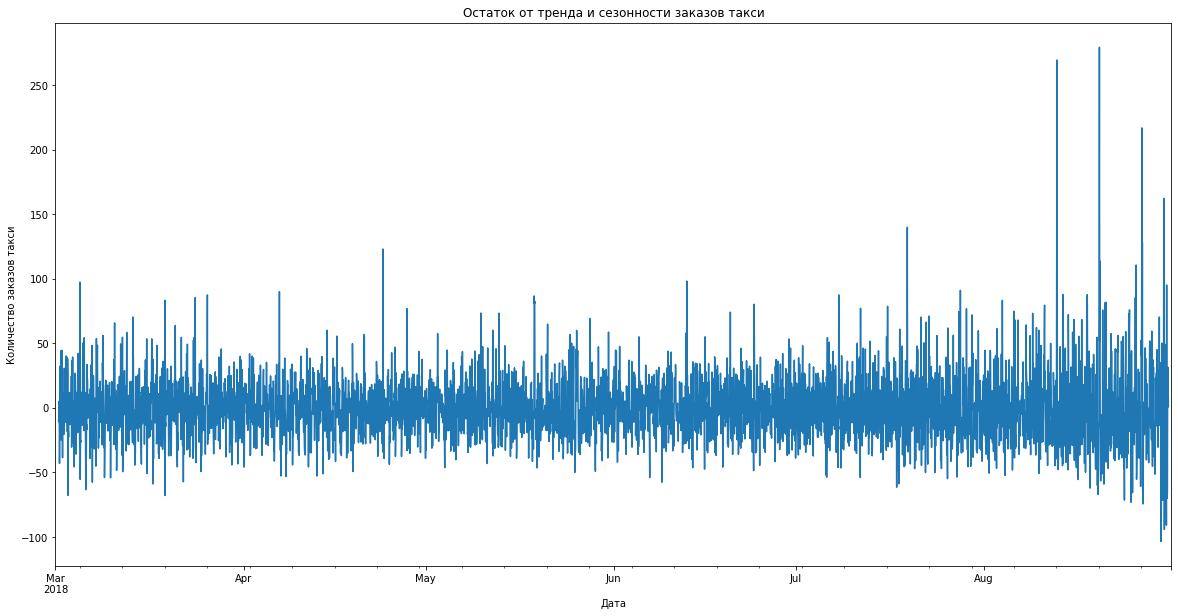

In [11]:
#посмотрим на график остатков

decomposed.resid.plot(figsize=(20,10))

plt.title('Остаток от тренда и сезонности заказов такси')
plt.xlabel('Дата')
plt.ylabel('Количество заказов такси')
plt.show()

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
По приведенным выше графикам видно, что наблюдается тренд на рост количества заказов такси в период летних каникул и ранней осени. Возможно это связано с более частыми перелетами в период отпусков. 
    <br>
    Для рассмотрения сезонности лучше выделить небольшой участок датафрейма и на нем более детально провести анализ. Возьмем двухнедельный период с 04-06-2018 по 17-06-2018. Также рассмотрим срез временного ряда в один день, чтобы оценить сезонность.
</div>

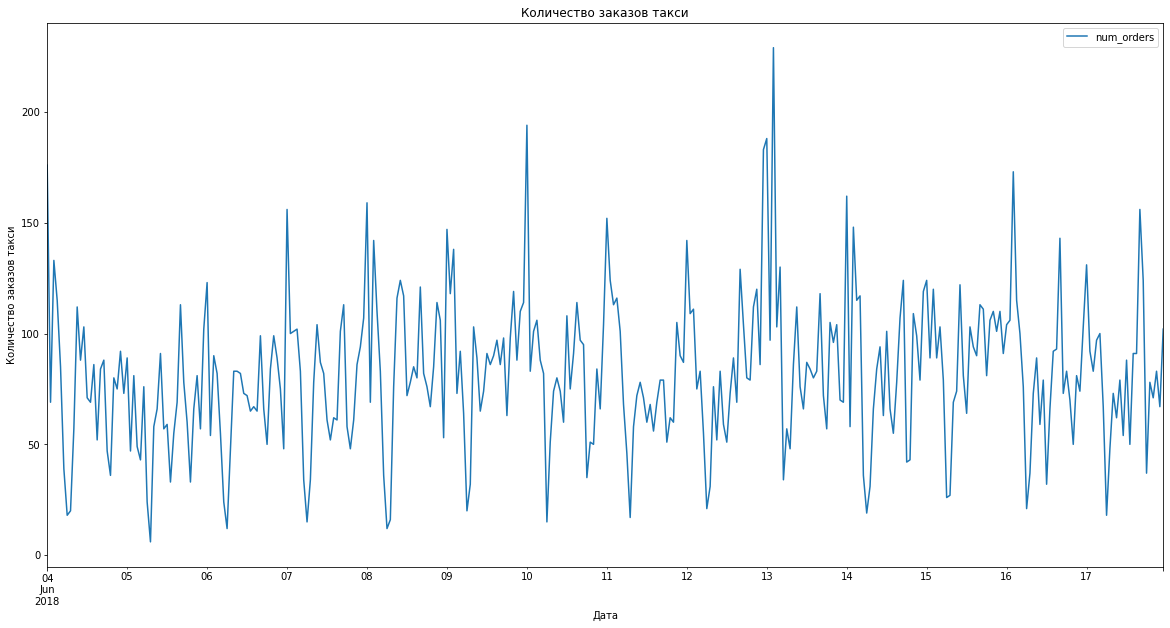

In [12]:
#посмотрим на двухнедельный график количества заказов такси 

data['2018-06-04':'2018-06-17'].plot(figsize=(20,10))

plt.title('Количество заказов такси')
plt.xlabel('Дата')
plt.ylabel('Количество заказов такси')
plt.show()

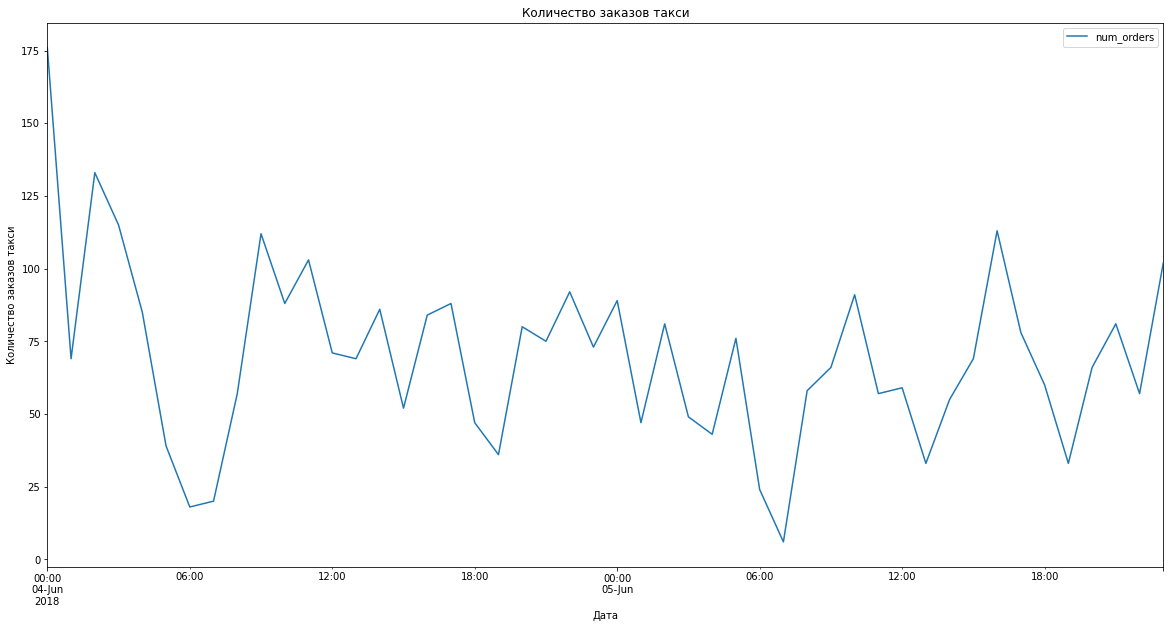

In [13]:
#посмотрим на дневной график количества заказов такси

data['2018-06-04':'2018-06-05'].plot(figsize=(20,10))

plt.title('Количество заказов такси')
plt.xlabel('Дата')
plt.ylabel('Количество заказов такси')
plt.show()

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
На двухнедельном графике наблюдается рост количества заказов такси по воскресеньям. А на дневном графике видно, что наименьшее количество заказов приходится на раннее утро, а наибольшее количество приходится на поздний вечер. Для определения стационарности временного ряда применим тест Дики-Фуллера.
</div>

In [14]:
test_fuller = adfuller(data)

print ('Значение коэффициента а: ', test_fuller[0]) 
print ('Значение p-value: ', test_fuller[1])
print ('Критические значения: ', test_fuller[4])
if test_fuller[0]> test_fuller[4]['5%']: 
    print ('Есть единичные корни, ряд не стационарен')
else:
    print ('Единичных корней нет, ряд стационарен')

Значение коэффициента а:  -3.0689242890279558
Значение p-value:  0.028940051402612906
Критические значения:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
Единичных корней нет, ряд стационарен


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Результаты теста показывают, что временной ряд стационарен. Также построим для нашего временного ряда график скользящего среднего и стандартного отклонения.
</div>

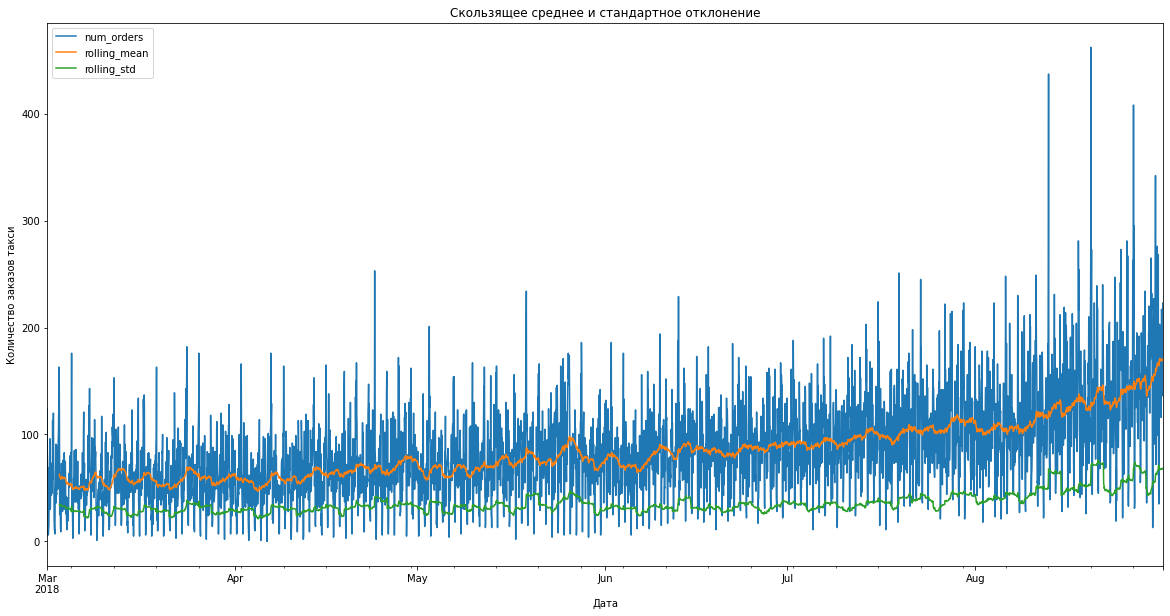

In [15]:
data['rolling_mean'] = data.num_orders.rolling(50).mean() 
data['rolling_std'] = data.num_orders.rolling(50).std()


data.plot(figsize=(20,10))

plt.title('Скользящее среднее и стандартное отклонение')
plt.xlabel('Дата')
plt.ylabel('Количество заказов такси')
plt.show()

## Обучение

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Для обучения и в дальнейшем для прогнозирования количества заказов такси добавим ряд новых признаков.
</div>

In [16]:
#напишем функцию для добавления новых признаков

def make_features(data, max_lag, rolling_mean_size):
    
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['weekday'] = data.index.weekday
    data['hour'] = data.index.hour
    data['weekend'] = (-data.weekday.isin([5,6])).astype(np.int8)
    data['morning'] = (-data.hour.isin(range(4,10))).astype(np.int8)
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
make_features(data, 6, 2)    

<div class="alert alert-block alert-info">
<b>Совет: </b> Желательно было написать функцию таким образом, чтобы она возвращала новый датафрейм, а не изменяла глобальную переменную.
</div>

In [17]:
#разделим нашу выборку на обучающую и тестовую
    
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)

target_train = train['num_orders']
target_test = test['num_orders']

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Перейдем к обучению моделей. Начнем с модели "Дерево решений". При обучении планирую использовать GridSearchCV, поэтому дополнительно создадим переменную, которая будет хранить в себе параметр кросс-валидации для временных рядов.
</div>

In [18]:
tscv = TimeSeriesSplit(n_splits=4)

In [19]:
%%time
#зададим гиперпараметры дерева решений

max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

max_features = [int(x) for x in np.linspace(1, 20, num = 10)]

dt_grid = {'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf,
           'max_features': max_features
           }

model_dt = GridSearchCV(DecisionTreeRegressor(random_state=12345), dt_grid, scoring = 'neg_root_mean_squared_error', cv = tscv)
# обучаем модель
model_dt.fit(features_train, target_train)

CPU times: user 31.1 s, sys: 0 ns, total: 31.1 s
Wall time: 31.3 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [1, 3, 5, 7, 9, 11, 13, 15, 17, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_root_mean_squared_error')

In [20]:
#определяем лучшие гиперпараметры для дерева решений

print('Наивысшая оценка: %s' % -model_dt.best_score_)
print('Лучшие гиперпараметры: %s' % model_dt.best_params_)

Наивысшая оценка: 29.64670616749404
Лучшие гиперпараметры: {'max_depth': 8, 'max_features': 15, 'min_samples_leaf': 4, 'min_samples_split': 10}


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Далее рассмотрим модель случайного леса.
</div>

In [21]:
%%time
#зададим гиперпараметры случайного леса

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 10, num = 11)]

max_depth = [int(x) for x in np.linspace(1, 5, num = 11)]

max_features = ['auto']

min_samples_split = [5, 10]

min_samples_leaf = [2, 4]

rf_grid = {'n_estimators': n_estimators,
           'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf
           }

model_rf = GridSearchCV(RandomForestRegressor(random_state=12345), rf_grid, scoring = 'neg_root_mean_squared_error', cv = tscv)
# обучаем модель
model_rf.fit(features_train,target_train)

CPU times: user 47.7 s, sys: 49.6 ms, total: 47.7 s
Wall time: 47.9 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 5],
                         'max_features': ['auto'], 'min_samples_leaf': [2, 4],
                         'min_samples_split': [5, 10],
                         'n_estimators': [1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='neg_root_mean_squared_error')

In [22]:
#определяем лучшие гиперпараметры для случайного леса

print('Наивысшая оценка: %s' % -model_rf.best_score_)
print('Лучшие гиперпараметры: %s' % model_rf.best_params_)

Наивысшая оценка: 29.118767333901424
Лучшие гиперпараметры: {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 10}


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Перейдем к модели линейной регрессии.
</div>

In [23]:
%%time

normalize = ['True', 'False']

lr_grid = {'normalize': normalize}

model_lr =  GridSearchCV(LinearRegression(), lr_grid, scoring = 'neg_root_mean_squared_error', cv = tscv)
# обучаем модель
model_lr.fit(features_train,target_train)

CPU times: user 481 ms, sys: 667 ms, total: 1.15 s
Wall time: 1.08 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=LinearRegression(),
             param_grid={'normalize': ['True', 'False']},
             scoring='neg_root_mean_squared_error')

In [24]:
#определяем лучшие гиперпараметры для линейной регрессии

print('Наивысшая оценка: %s' % -model_lr.best_score_)
print('Лучшие гиперпараметры: %s' % model_lr.best_params_)

Наивысшая оценка: 30.109749799073434
Лучшие гиперпараметры: {'normalize': 'True'}


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Далее обучим модель бустинга CatBoostRegressor.
</div>

In [25]:
%%time

n_estimators = [10, 30, 50, 70, 100]
depth = [1, 3, 5, 7, 10]

cb_grid = {'n_estimators': n_estimators,
           'depth': depth}

model_cb =  GridSearchCV(CatBoostRegressor(random_seed=12345), cb_grid, scoring = 'neg_root_mean_squared_error', cv = tscv)
# обучаем модель
model_cb.fit(features_train,target_train)

Learning rate set to 0.5
0:	learn: 26.0898853	total: 46.6ms	remaining: 419ms
1:	learn: 24.2676555	total: 46.9ms	remaining: 188ms
2:	learn: 23.6132176	total: 47.2ms	remaining: 110ms
3:	learn: 23.1487606	total: 47.5ms	remaining: 71.2ms
4:	learn: 22.7098150	total: 47.7ms	remaining: 47.7ms
5:	learn: 22.2303057	total: 48.1ms	remaining: 32ms
6:	learn: 21.8860262	total: 48.3ms	remaining: 20.7ms
7:	learn: 21.4158134	total: 48.6ms	remaining: 12.2ms
8:	learn: 21.0843627	total: 48.9ms	remaining: 5.43ms
9:	learn: 20.8692412	total: 49.2ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 28.1060557	total: 430us	remaining: 3.88ms
1:	learn: 26.8218603	total: 896us	remaining: 3.59ms
2:	learn: 25.5984613	total: 1.35ms	remaining: 3.15ms
3:	learn: 24.9779836	total: 1.72ms	remaining: 2.58ms
4:	learn: 24.6508437	total: 2.09ms	remaining: 2.09ms
5:	learn: 24.2784037	total: 2.52ms	remaining: 1.68ms
6:	learn: 23.6766288	total: 2.81ms	remaining: 1.2ms
7:	learn: 23.3137368	total: 3.13ms	remaining: 783us
8:	learn

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f494a081550>,
             param_grid={'depth': [1, 3, 5, 7, 10],
                         'n_estimators': [10, 30, 50, 70, 100]},
             scoring='neg_root_mean_squared_error')

In [26]:
#определяем лучшие гиперпараметры для CatBoostRegressor

print('Наивысшая оценка: %s' % -model_cb.best_score_)
print('Лучшие гиперпараметры: %s' % model_cb.best_params_)

Наивысшая оценка: 26.178806762994604
Лучшие гиперпараметры: {'depth': 5, 'n_estimators': 100}


In [27]:
speed_and_scoring = pd.DataFrame({'Модель регрессии': 
                                  ['Дерево решений', 'Случайный лес', 'Линейная регрессия','CatBoostRegressor'],
                                 'Время обучения модели': 
                                  ['30.7s', '47.4s', '1.24s',  '1min 2s'],
                                 'Метрика RMSE на обучающей выборке': 
                                  ['29.65', '29.12', '30.11', '26.18']                                 
                                 })
speed_and_scoring

,Модель регрессии,Время обучения модели,Метрика RMSE на обучающей выборке
0,Дерево решений,30.7s,29.65
1,Случайный лес,47.4s,29.12
2,Линейная регрессия,1.24s,30.11
3,CatBoostRegressor,1min 2s,26.18


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Наилучший результат по качеству метрики RMSE показал бустинг CatBoostRegressor. Примем его параметры для получения предсказания количества заказов такси.
</div>

## Тестирование

In [34]:
%%time 

#получение предсказания модели CatBoostRegressor на тестовой выборке

predicted_cb_test = model_cb.predict(features_test)

print('Метрика качества RMSE на модели CatBoostRegressor на тестовой выборке:{:.2f}'.
      format(mean_squared_error(predicted_cb_test, target_test)**0.5))

Метрика качества RMSE на модели CatBoostRegressor на тестовой выборке:43.46
CPU times: user 3.75 ms, sys: 0 ns, total: 3.75 ms
Wall time: 3.61 ms


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Построим константную модель для сравнения полученных результатов.
</div>

In [29]:
%%time

#зададим гиперпараметры для DummyRegressor

strategy = ['mean', 'median', 'quantile', 'constant']

dr_grid = {'strategy': strategy}

model_dr = GridSearchCV(DummyRegressor(), dr_grid, scoring = 'neg_root_mean_squared_error', cv = tscv)
# обучаем модель
model_dr.fit(features_train,target_train)

CPU times: user 33.1 ms, sys: 53 µs, total: 33.1 ms
Wall time: 64.3 ms


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median', 'quantile',
                                      'constant']},
             scoring='neg_root_mean_squared_error')

In [30]:
#определяем лучшие гиперпараметры для DummyRegressor

print('Наивысшая оценка: %s' % -model_dr.best_score_)
print('Лучшие гиперпараметры: %s' % model_dr.best_params_)

Наивысшая оценка: 41.39812384409484
Лучшие гиперпараметры: {'strategy': 'mean'}


In [31]:
%%time

#получение предсказания модели DummyRegressor на тестовой выборке

predicted_dr_test = model_dr.predict(features_test)

print('Метрика качества RMSE на модели DummyRegressor на тестовой выборке:{:.2f}'.
      format(mean_squared_error(predicted_dr_test, target_test)**0.5))

Метрика качества RMSE на модели DummyRegressor на тестовой выборке:84.60
CPU times: user 1.09 ms, sys: 65 µs, total: 1.16 ms
Wall time: 1.06 ms


In [32]:
compare_model = pd.DataFrame({'Модель регрессии': 
                                  ['CatBoostRegressor', 'DummyRegressor'],
                                 'Время предсказания модели': 
                                  ['2.03 ms', '1.45 ms'],
                                 'Метрика RMSE на тестовой выборке': 
                                  ['43.46', '84.60']                                 
                                 })
compare_model

,Модель регрессии,Время предсказания модели,Метрика RMSE на тестовой выборке
0,CatBoostRegressor,2.03 ms,43.46
1,DummyRegressor,1.45 ms,84.60


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Модель DummyRegressor показала результаты значительно хуже, т.к. метрика RMSE получилась выше. Значит построенная нами модель CatBoostRegressor вполне адекватна.
</div>

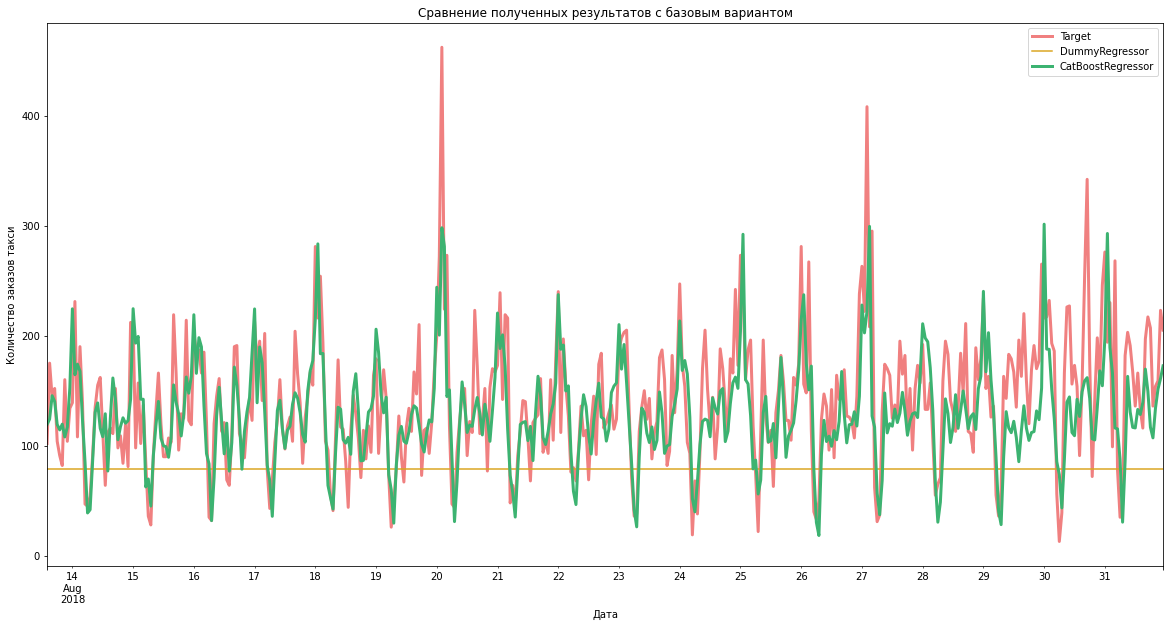

In [64]:
#проведем сравнение полученных результатов с базовым вариантом

target_test.plot(figsize=(20,10), color='lightcoral', linewidth=3.0)
pd.Series(predicted_dr_test, name='num_orders', index=target_test.index).plot(figsize=(20,10), color='goldenrod')
pd.Series(predicted_cb_test, name='num_orders', index=target_test.index).plot(figsize=(20,10), color='mediumseagreen', linewidth=3.0)

plt.legend(loc='upper right', labels=['Target','DummyRegressor','CatBoostRegressor'])
plt.title('Сравнение полученных результатов с базовым вариантом')
plt.xlabel('Дата')
plt.ylabel('Количество заказов такси')
plt.show()

<div class="alert alert-info">
<b>Комментарий студента V2:</b>
<br>
По графику видно, что предсказания от CatBoostRegressor достаточно точно повторяют истинные значения в начальном периоде предсказания, а в конце предсказания уже появляются достаточно частые расхождения.
</div>